In [713]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from skimage import io, color, transform
import matplotlib.pyplot as plt

In [714]:
# read directory

rgb_dir = os.path.join(os.getcwd(), 'dataset', '1_RGB_Frames')
depth_img_dir = os.path.join(os.getcwd(), 'dataset', '2_Depth_Frames', 'IMG')
depth_csv_dir = os.path.join(os.getcwd(), 'dataset', '2_Depth_Frames', 'CSV')

rgb_files = os.listdir(rgb_dir)
depth_img_files = os.listdir(depth_img_dir)
depth_csv_files = os.listdir(depth_csv_dir)

print('RGB files: ', len(rgb_files))
print('Depth image files: ', len(depth_img_files))
print('Depth csv files: ', len(os.listdir(depth_csv_dir)))

RGB files:  50
Depth image files:  50
Depth csv files:  50


In [715]:
timestamp_extraction = lambda x: x.split('_')[-1].rstrip('.png').split('.')[0]

In [716]:
dataset = []
index = 0
for rgb_file in rgb_files:
    rgb_file_path = os.path.join(rgb_dir, rgb_file)
    timestamp = timestamp_extraction(rgb_file)
    # find depth image thqt matches the timestamp
    try:
        depth_img_file = [x for x in depth_img_files if timestamp in x][0]
        depth_img_file_path = os.path.join(depth_img_dir, depth_img_file)
        # find depth csv file that matches the timestamp
        depth_csv_file = [x for x in depth_csv_files if timestamp in x][0]
        depth_csv_file_path = os.path.join(depth_csv_dir, depth_csv_file)
    except:
        print('No depth file for ', rgb_file)
        continue

    dataset.append({
        'rgb': rgb_file_path,
        'depth_img': depth_img_file_path,
        'depth_csv': depth_csv_file_path,
        'index': index
    })
    index += 1


No depth file for  20221117_124001_Color_1668669001690.01220703125000.png


In [717]:
def read_rgb_img(rgb_img_file_path):
    rgb_img = io.imread(rgb_img_file_path)
    rgb_img = transform.resize(rgb_img, (480, 848))
    rgb_img = color.rgb2gray(rgb_img)
    return rgb_img

def cluster_rgb(rgb_img_file_path, n_clusters=3):
    rgb = read_rgb_img(rgb_img_file_path)
    rgb = rgb.reshape(-1, 1)
    print(rgb.shape)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(rgb)
    return kmeans.labels_

def plot_rgb_img(rgb_img_file_path, rgb_labels):
    rgb_img = read_rgb_img(rgb_img_file_path)
    # plt.imshow(rgb_img, cmap='gray')
    # reshape the labels to match the shape of the image
    rgb_labels = rgb_labels.reshape(rgb_img.shape)
    io.imshow(rgb_labels)
    io.show()

(407040, 1)


c:\Users\anish_n48e8\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anish_n48e8\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


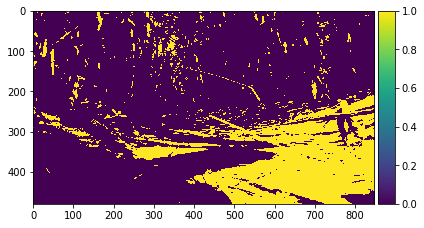

In [718]:
import random

sample = random.choice(dataset)

rgb_labels = cluster_rgb(sample['rgb'], 2)
plot_rgb_img(sample['rgb'], rgb_labels)

In [719]:
def read_depth_img(depth_img_file_path):
    depth_img = io.imread(depth_img_file_path)
    depth_img = transform.resize(depth_img, (480, 848))
    depth_img = color.rgb2gray(depth_img)
    return depth_img

def cluster_depth(depth_csv_file_path, n_clusters=3):
    # read depth csv file
    depth = pd.read_csv(depth_csv_file_path, header=None)
    # flatten the depth array
    # replace 0 values with 1
    depth = depth.values.flatten()
    depth = depth / depth.max()
    depth[depth == 0] = 1
    depth = depth.reshape(-1, 1)
    print(depth.shape)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(depth)
    return kmeans.labels_

def plot_depth_img(depth_img_file_path, depth_labels):
    depth_img = read_depth_img(depth_img_file_path)
    plt.imshow(depth_img, cmap='gray')
    # reshape the labels to match the shape of the image
    depth_labels = depth_labels.reshape(depth_img.shape)
    io.imshow(depth_labels, alpha=0.5)
    io.show()

(407040, 1)


c:\Users\anish_n48e8\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anish_n48e8\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


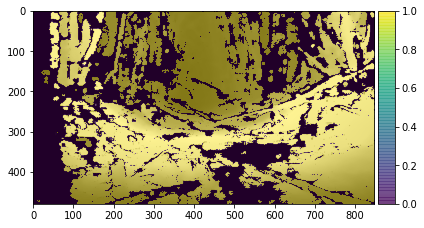

In [720]:
depth_labels = cluster_depth(sample['depth_csv'], 2)
plot_depth_img(sample['depth_img'], depth_labels)

In [721]:
rgb_labels.shape

(407040,)

In [722]:
depth_labels.shape

(407040,)

In [723]:
combined_labels = 5 * rgb_labels + depth_labels


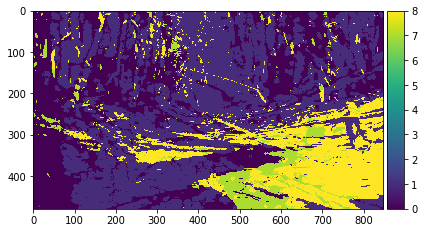

In [724]:
plot_rgb_img(sample['rgb'], combined_labels)

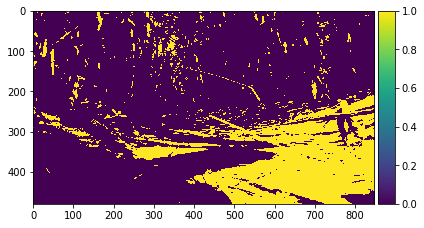

In [725]:
clcopy = combined_labels.copy()
# replace anything less than 4 with 0
num = 7
clcopy[clcopy < num] = 0
# replace anything greater than 4 with 1
clcopy[clcopy >= num] = 1
# plot the combined labels
plot_rgb_img(sample['rgb'], clcopy)


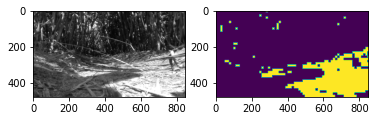

In [727]:
# reshape clcopy to match the shape of the image
clcopy = clcopy.reshape(read_rgb_img(sample['rgb']).shape)
# take XxX window of the image, and plot most common label
def plot_window(rgb_img_file_path, clcopy, window_size=10, mode='mean'):
    rgb_img = read_rgb_img(rgb_img_file_path)
    # iterate over the image
    for i in range(0, rgb_img.shape[0], window_size):
        for j in range(0, rgb_img.shape[1], window_size):
            # get the window
            window = clcopy[i:i+window_size, j:j+window_size]
            # get the most common label
            if mode == 'common':
                most_common_label = np.bincount(window.flatten()).argmax()
                # get mean of the window
            elif mode == 'mean':
                # calculate the mean of the window without using inbuilt functions
                sum_non_zero = np.sum(window)
                # calculate the mean
                most_common_label = sum_non_zero / (window_size * window_size)
            # replace the window with most common label
            clcopy[i:i+window_size, j:j+window_size] = most_common_label
    # plot the image, and the original image side by side
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # save clcopy as csv
    ax1.imshow(rgb_img, cmap='gray')
    # plot clcopy, which is an array of decimal numbers, as a heatmap
    ax2.imshow(clcopy)
    plt.show()

plot_window(sample['rgb'], clcopy, 12, 'common')